
(ﾉ ﾟｰﾟ)ﾉ
Tutorial (probably): https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

(ﾉ ﾟｰﾟ)ﾉ
Models:
https://pytorch.org/vision/stable/models.html#general-information-on-pre-trained-weights

(ﾉ ﾟｰﾟ)ﾉ
Datasets:
https://pytorch.org/vision/stable/datasets.html

In [17]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import random

cudnn.benchmark = True
plt.ion()   # interactive mode

#don't forget: net.to(device)

## Hyperparams

In [18]:
batch_size=64
n_threads = 4

# hardware dependent:
data_folder = '.data'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Task1 - Dataset
Loading set + showing example images and size



### Load and visualize data

In [19]:
# new 
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

feature_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
    # transforms.Resize(256),
    transforms.ToTensor(),
])

# Create Omniglot dataset
trainset = torchvision.datasets.Flowers102(root=data_folder, split="train",
                                        download=True, transform=feature_transforms)

testset = torchvision.datasets.Flowers102(root=data_folder, split="test",
                                        download=True, transform=feature_transforms)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

trainsize = len(trainset)
testsize = len(testset)

#class_names = trainset.classes


In [20]:
trainset[0][0]


tensor([[[0.6627, 0.7216, 0.7608,  ..., 0.1176, 0.1608, 0.2196],
         [0.6510, 0.7216, 0.7569,  ..., 0.0980, 0.1294, 0.1804],
         [0.6588, 0.6902, 0.7569,  ..., 0.1098, 0.1255, 0.1647],
         ...,
         [0.0863, 0.0706, 0.0549,  ..., 0.6275, 0.6549, 0.6706],
         [0.0667, 0.0549, 0.0549,  ..., 0.6000, 0.5882, 0.5961],
         [0.0706, 0.0824, 0.0745,  ..., 0.6471, 0.6588, 0.6549]],

        [[0.5176, 0.5686, 0.6392,  ..., 0.0863, 0.0902, 0.1137],
         [0.5098, 0.5686, 0.6431,  ..., 0.0902, 0.0902, 0.1137],
         [0.5020, 0.5412, 0.6471,  ..., 0.0980, 0.1098, 0.1412],
         ...,
         [0.1059, 0.1020, 0.0980,  ..., 0.5216, 0.5451, 0.5608],
         [0.1137, 0.1059, 0.1059,  ..., 0.4824, 0.4745, 0.4902],
         [0.1176, 0.1333, 0.1255,  ..., 0.5529, 0.5804, 0.5882]],

        [[0.4510, 0.6235, 0.7373,  ..., 0.0510, 0.0667, 0.1137],
         [0.4353, 0.5961, 0.7176,  ..., 0.0549, 0.0627, 0.1020],
         [0.4667, 0.5608, 0.7020,  ..., 0.0627, 0.0863, 0.

Dataset length:  Dataset Flowers102
    Number of datapoints: 1020
    Root location: .data
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )


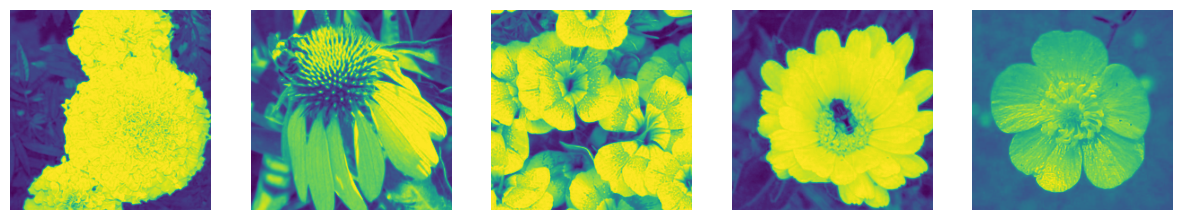

In [21]:
print('Dataset length: ', trainset)

# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# get some random training images

random_indices = random.sample(range(len(trainset)), 5)
random_images = [trainset[i][0][0] for i in random_indices]
# Display random images
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(random_images[i])
    axs[i].axis('off')

plt.show()

### Finetuning
- every layer

In [22]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

use_previous_net_as_fixed_feature_extractor = False
if use_previous_net_as_fixed_feature_extractor:
    for param in model_ft.parameters():
        param.requires_grad = False

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to the number of character classes in the dataset
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
num_characters = 102
model_ft.fc = nn.Linear(num_ftrs, num_characters)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in trainloader if phase == "train" else testloader:
                    # inputs = inputs.squeeze()
                    # inputs = torch.stack((inputs, inputs, inputs), dim=1)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    scheduler.step()

                used_set = trainset if phase == "train" else testset
                epoch_loss = running_loss / len(used_set)
                epoch_acc = running_corrects.double() / len(used_set)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [24]:
# Training results:
# ResNet as fixed feature extractor:
# train Loss: 4.6262 Acc: 0.3691
# val Loss: 7.1563 Acc: 0.0011
# Training complete in 11m 28s
# Best val Acc: 0.001745

# ResNet finetuned:
# train Loss: 4.6204 Acc: 0.3607
# val Loss: 7.1723 Acc: 0.0011
# Training complete in 12m 40s
# Best val Acc: 0.001138

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 4.7876 Acc: 0.0157
val Loss: 4.6767 Acc: 0.0158

Epoch 1/24
----------
train Loss: 4.5935 Acc: 0.0294
val Loss: 4.5061 Acc: 0.0371

Epoch 2/24
----------
train Loss: 4.4244 Acc: 0.0578
val Loss: 4.3879 Acc: 0.0602

Epoch 3/24
----------
train Loss: 4.2664 Acc: 0.0873
val Loss: 4.2685 Acc: 0.0961

Epoch 4/24
----------
train Loss: 4.1215 Acc: 0.1686
val Loss: 4.1463 Acc: 0.1506

Epoch 5/24
----------
train Loss: 3.9750 Acc: 0.2441
